In [1]:
import pandas as pd
df = pd.read_csv('../data/processed/cleaned_data.csv')

# Quick look
df.head()

,amt,gender,city_pop,is_fraud,trans_hour,trans_day,trans_weekday,trans_month,age,merchant_enc,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_enc
0,-0.424463,0,0.816521,0,-0.118789,0.506526,1.502388,-1.773597,0.302549,-0.622497,...,0,0,0,0,0,1,0,0,0,0.022567
1,-0.252337,1,-0.292685,0,-0.118789,0.506526,1.502388,-1.773597,-0.901025,-0.406216,...,0,0,0,0,0,1,0,0,0,0.008382
2,-0.179353,1,-0.178853,0,-0.118789,0.506526,1.502388,-1.773597,0.187923,-0.538633,...,1,0,0,0,0,0,0,0,0,0.064633
3,-0.059605,0,-0.111371,0,-0.118789,0.506526,1.502388,-1.773597,-0.786399,-0.732844,...,0,0,0,0,1,0,0,0,0,0.032578
4,-0.422358,0,-0.289942,0,-0.118789,0.506526,1.502388,-1.773597,1.047618,-2.237981,...,0,0,0,0,0,0,0,0,1,0.035397


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   amt                      555719 non-null  float64
 1   gender                   555719 non-null  int64  
 2   city_pop                 555719 non-null  float64
 3   is_fraud                 555719 non-null  int64  
 4   trans_hour               555719 non-null  float64
 5   trans_day                555719 non-null  float64
 6   trans_weekday            555719 non-null  float64
 7   trans_month              555719 non-null  float64
 8   age                      555719 non-null  float64
 9   merchant_enc             555719 non-null  float64
 10  job_enc                  555719 non-null  float64
 11  category_food_dining     555719 non-null  int64  
 12  category_gas_transport   555719 non-null  int64  
 13  category_grocery_net     555719 non-null  int64  
 14  cate

In [3]:
# Separate target and features
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Check shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (555719, 24)
y shape: (555719,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
#stratify=y is used because the the target distrubution is highly imbalanced, if 0.4% of the taget is fraud then while splitting it 0.2% can be sent to training and 0.8% can be sent to testing which will mean the model learns poorly, so if we use stratify the splitting of the target is even in the traing and testing set

Train shape: (444575, 24)
Test shape: (111144, 24)


In [5]:
print("Train distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest distribution:")
print(y_test.value_counts(normalize=True))

Train distribution:
is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64

Test distribution:
is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64


In [6]:
#we can see both traing and testing sets have same proportion of distribution of sets

Logistic regression:

In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    class_weight='balanced',   # handles imbalance
    #Automatically increases the importance (weight) of fraud samples
    #Penalizes mistakes on fraud more than mistakes on non-fraud
    #internally [ weight(class) = total_samples / (n_classes × samples_in_class) ]  Improves fraud recall,Prevents model from predicting “not fraud” always
    max_iter=1000, #Ensures convergence
    n_jobs=-1 #Uses all available CPU cores
)

lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    110715
           1       0.02      0.74      0.05       429

    accuracy                           0.89    111144
   macro avg       0.51      0.81      0.49    111144
weighted avg       1.00      0.89      0.94    111144

ROC-AUC: 0.9143648084442015


Precision: Of all the times the model predicted 'Positive,' how often was it actually right?, So it means all the prediction of non fraud was true but only 2% of fraud prediction was actually fraud.

Recall : Of all the actual 'Positive' cases that exist, how many did the model find?, So it means that 89% of genuine transaction was cleared, rest 11% was detected fraud, and 74% of fraud transaction was detected and 26% of fraud traction was not detected.

The F1-Score is the "middle ground." It combines Precision and Recall into a single number using a harmonic mean.F1 = 2 × (Precision × Recall) / (Precision + Recall).Precision is extremely low in fraud detected. F1 penalizes imbalance between precision and recall.

Support is the number of non fraud and fraud.

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[98136 12579]
 [  110   319]]


TN = 98,122

FP = 12,593

FN = 110

TP = 319

Random forest:

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200, #Number of decision trees in the forest,One decision tree can overfit.Many trees:Reduce variance,Improve generalization
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.98      0.67      0.80       429

    accuracy                           1.00    111144
   macro avg       0.99      0.83      0.90    111144
weighted avg       1.00      1.00      1.00    111144

ROC-AUC: 0.9887691122347674


Precision = 0.98    When the model says “Fraud”, it is correct 98% of the time, better than 2% in logistic

Recall = 0.66     BUT it only catches 66% of all actual frauds, 34% frauds are being missed(false negative)

F1 = 0.79     

False negatives are still significant

Since there is to many recall we can lower the threshold

In [12]:
y_prob = rf.predict_proba(X_test)[:, 1]

yesle chai x test ma aauni non fraud ko probability ra fraude ko probability lai nikalxa so[:,1] bhaneko all rows and second column ho jun column is fraud ko ho, tesko yesle probability nikalera y_prob bhanni ma as a list store garxa

In [13]:
y_pred = (y_prob >= 0.3).astype(int)

yesle chai if the probability >= 30 then it detects fraud(1) else not fraud

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

[[110693     22]
 [    95    334]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.94      0.78      0.85       429

    accuracy                           1.00    111144
   macro avg       0.97      0.89      0.93    111144
weighted avg       1.00      1.00      1.00    111144

ROC-AUC: 0.9887691122347674


So we can see that the recall increased a lot and precision decreased a little and overall f1 score also increased

In [15]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_prob = rf.predict_proba(X_test)[:, 1]
threshold = 0.2    #reducing the threshold even more
y_pred = (y_prob >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


[[110655     60]
 [    77    352]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.85      0.82      0.84       429

    accuracy                           1.00    111144
   macro avg       0.93      0.91      0.92    111144
weighted avg       1.00      1.00      1.00    111144

ROC-AUC: 0.9887691122347674


In [16]:
#compared to threshold 30% the recall increased by 6% but precision decreased by 7%. So having threshold 30% is better

In [17]:
import pandas as pd

importance = pd.Series(
    rf.feature_importances_, #A NumPy array produced by Random Forest. Each value represents: How much that feature contributed to reducing impurity (Gini)
    index=X.columns #Assigns feature names to importance values
).sort_values(ascending=False)

importance.head(10)
# higher value means feature splits data more effectively

amt                      0.491725
trans_hour               0.168535
merchant_enc             0.046167
city_pop                 0.032887
age                      0.030393
job_enc                  0.030340
trans_day                0.025468
trans_month              0.022740
state_enc                0.021807
category_shopping_net    0.020104
dtype: float64

XGBoost:

In [18]:
from xgboost import XGBClassifier

In [19]:
xgb = XGBClassifier(
    n_estimators=200,                      # number of trees
    max_depth=6,                           # max depth of trees
    learning_rate=0.05,                    # step size
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),  # handle imbalance
    objective='binary:logistic',           # binary classification
    eval_metric='auc',                     # metric to optimize
    random_state=42,
    n_jobs=-1
)

In [20]:
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [21]:
y_prob = xgb.predict_proba(X_test)[:,1]  # probabilities
y_pred = (y_prob >= 0.5).astype(int)     # simple threshold

In [22]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    110715
           1       0.28      0.97      0.43       429

    accuracy                           0.99    111144
   macro avg       0.64      0.98      0.71    111144
weighted avg       1.00      0.99      0.99    111144

ROC-AUC: 0.9979465009542235
Confusion Matrix:
 [[109635   1080]
 [    13    416]]


In [23]:
threshold = 0.7 
y_pred_thresh = (y_prob >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    110715
           1       0.40      0.94      0.56       429

    accuracy                           0.99    111144
   macro avg       0.70      0.97      0.78    111144
weighted avg       1.00      0.99      1.00    111144



In [24]:
threshold = 0.8 
y_pred_thresh = (y_prob >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.50      0.91      0.65       429

    accuracy                           1.00    111144
   macro avg       0.75      0.95      0.82    111144
weighted avg       1.00      1.00      1.00    111144



In [25]:
threshold = 0.9  
y_pred_thresh = (y_prob >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.69      0.87      0.77       429

    accuracy                           1.00    111144
   macro avg       0.84      0.93      0.88    111144
weighted avg       1.00      1.00      1.00    111144



Observations 
                   precision,recall,f1
Logistic Regression	0.02	0.74	0.05	Baseline linear model, almost all predicted frauds are false positives → very poor precision
Random Forest 0.3	0.94	0.77	0.84	High precision, moderate recall → very few false alarms(false positive), misses some frauds.
Random Forest 0.2	0.87	0.83	0.85	Balanced trade-off → slightly lower precision, higher recall → slightly better F1 than 0.3 threshold.
XGBoost 0.7	        0.40	0.94	0.56	High recall, low precision → catches almost all frauds, but many false positives.
XGBoost 0.8     	0.51	0.91	0.65	Slightly better precision, slightly lower recall → better balance than 0.7 threshold.
XGBoost 0.9      	0.68	0.85	0.75	Highest F1 for XGBoost → best trade-off between precision and recall.


Recommendations

For business where missing fraud is costly → prioritize recall
XGBoost threshold 0.7 → recall 0.94 (almost all fraud caught)

For balanced performance → prioritize F1
Random Forest threshold 0.2 → F1 0.85 → very strong precision & recall trade-off

In [26]:
import joblib

In [30]:
joblib.dump(rf, "../models/random_forest_model.pkl")

['../models/random_forest_model.pkl']

                    feature  importance
0                       amt    0.491725
3                trans_hour    0.168535
8              merchant_enc    0.046167
2                  city_pop    0.032887
7                       age    0.030393
9                   job_enc    0.030340
4                 trans_day    0.025468
6               trans_month    0.022740
23                state_enc    0.021807
20    category_shopping_net    0.020104
13     category_grocery_pos    0.018759
11   category_gas_transport    0.015867
5             trans_weekday    0.014168
17        category_misc_net    0.008946
1                    gender    0.008204
15            category_home    0.006964
10     category_food_dining    0.006886
16       category_kids_pets    0.006231
21    category_shopping_pos    0.004952
18        category_misc_pos    0.004341
12     category_grocery_net    0.004146
22          category_travel    0.004144
19   category_personal_care    0.003564
14  category_health_fitness    0.002660


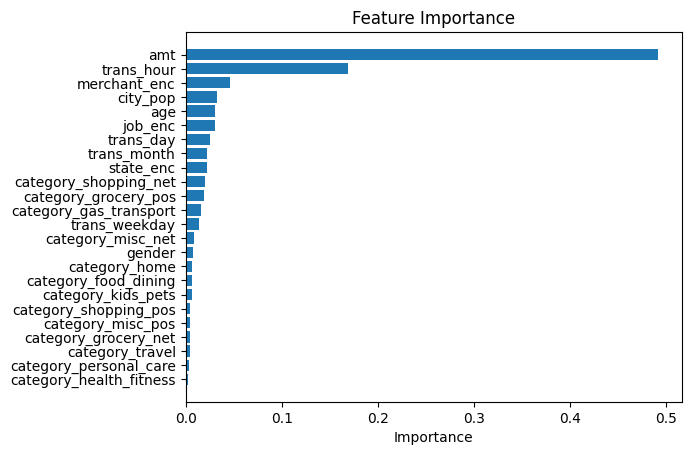

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
importance = rf.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Show
print(feature_importance_df)

# Plot
plt.figure()
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()

In [32]:
fraud_df = df[df['is_fraud'] == 1][
    [ 'amt', 'trans_hour', 'merchant_enc', 'city_pop', 'age', 'job_enc', 'trans_day', 'trans_month','state_enc']
]
fraud_df.head(30)

,amt,trans_hour,merchant_enc,city_pop,age,job_enc,trans_day,trans_month,state_enc
1685,-0.284236,1.349442,-0.626911,-0.293614,0.245236,0.600314,0.506526,-1.773597,0.072686
1767,4.536818,1.349442,-1.659761,-0.289343,0.875679,-1.702174,0.506526,-1.773597,0.022259
1781,3.514845,1.349442,-0.159039,-0.289343,0.875679,-1.702174,0.506526,-1.773597,0.022259
1784,6.432690,1.349442,-0.207591,-0.056216,-1.187590,0.075916,0.506526,-1.773597,0.016174
1857,4.933192,1.496265,0.569253,-0.293614,0.245236,0.600314,0.506526,-1.773597,0.072686
1891,-0.298846,1.496265,-0.569530,0.057978,-0.729086,1.037891,0.506526,-1.773597,0.032578
1906,6.755315,1.496265,-0.088416,-0.056216,-1.187590,0.075916,0.506526,-1.773597,0.016174
1956,5.502075,1.496265,-0.344422,-0.056216,-1.187590,0.075916,0.506526,-1.773597,0.016174
1968,5.828591,1.496265,-0.088416,-0.056216,-1.187590,0.075916,0.506526,-1.773597,0.016174
2026,5.650979,1.496265,-0.176694,-0.289343,0.875679,-1.702174,0.506526,-1.773597,0.022259
